In [2]:
# from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
#                         plt, cmap, Model, Data, ODR, datetime, rasterio, show, \
#                         ccrs, cfeature
# from scripts.classes_fixed import *
# from scripts.pvpg_fixed import *
# from scripts.track_pairs import *

# %matplotlib ipympl

# dirpath = '../data/rovaniemi_w/'
# all_ATL03, all_ATL08 = track_pairs(dirpath)
                             
# N = len(all_ATL03)
# for i in [0,1,2,3,4]:
#     pvpg_penalized_flagged(all_ATL03[i], all_ATL08[i],file_index=i, loss='arctan')

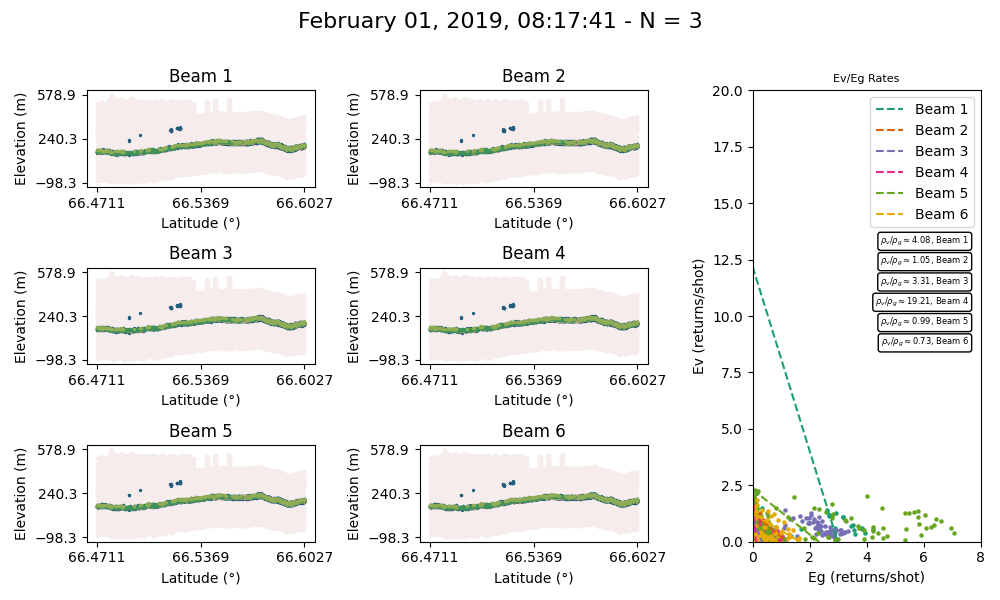

In [3]:
from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, cmap2, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
from scripts.classes_fixed import *
from scripts.pvpg_fixed import *
from scripts.track_pairs import *
from scripts.show_tracks import *

%matplotlib ipympl

dirpath = '../data/rovaniemi_w/'
all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

for j in range(3,4):
    pvpg_concise(all_ATL03[j],all_ATL08[j],
                           f_scale=.1,
                           loss = 'arctan',
                           zeros = False,
                           #beam = 4,
                           detail = 2,
                           file_index=j)

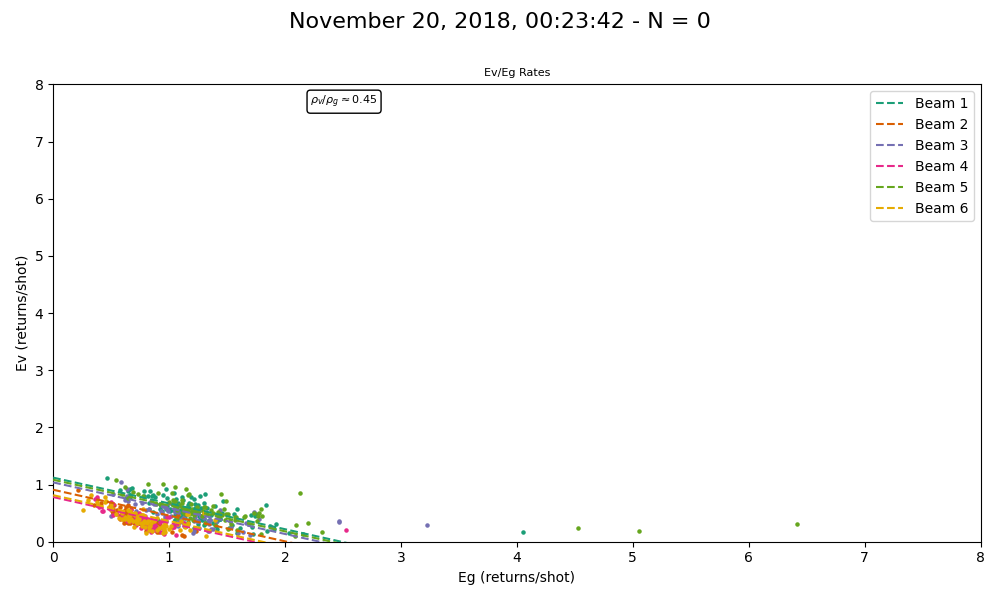

File 1 has been skipped.


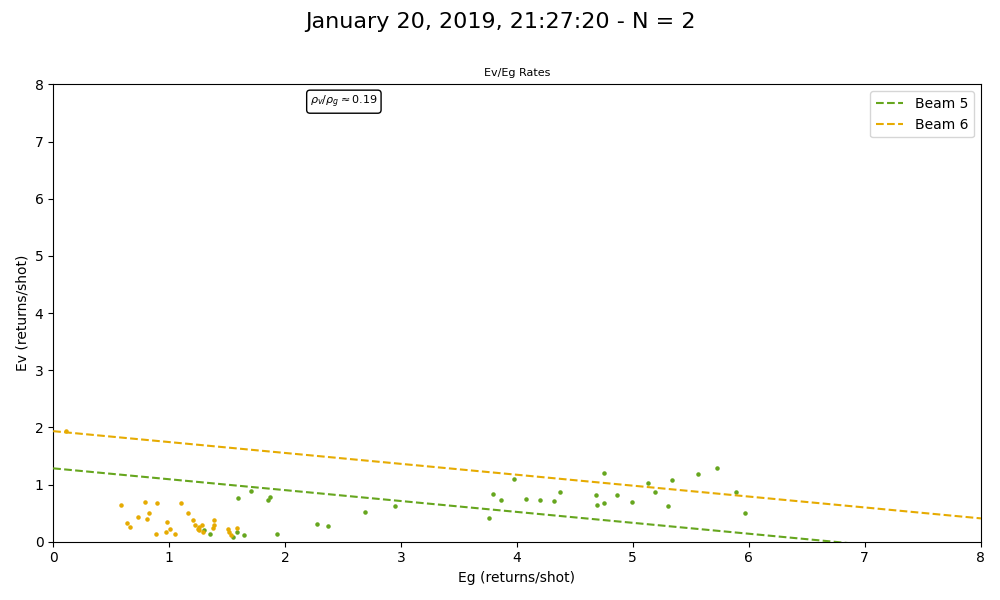

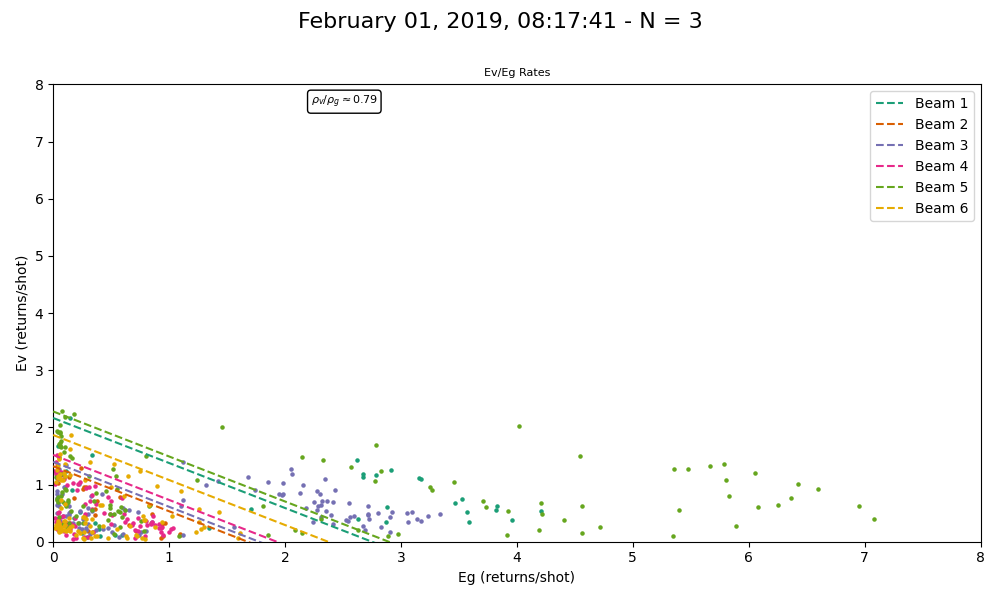

In [1]:
from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, cmap2, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
from scripts.classes_fixed import *
from scripts.pvpg_fixed import *
from scripts.track_pairs import *
from scripts.show_tracks import *
from scripts.parallel import pvpg_parallel_method1

%matplotlib ipympl

dirpath = '../data/rovaniemi_w/'
all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

for j in range(0,4):
    pvpg_parallel_method1(all_ATL03[j],all_ATL08[j],
                           init = -.1,
                           # f_scale=.1,
                           loss = 'linear',
                           zeros = False,
                           #beam = 5,
                           y_init = np.max, #alternatively np.max
                           graph_detail = True,
                           file_index=j)

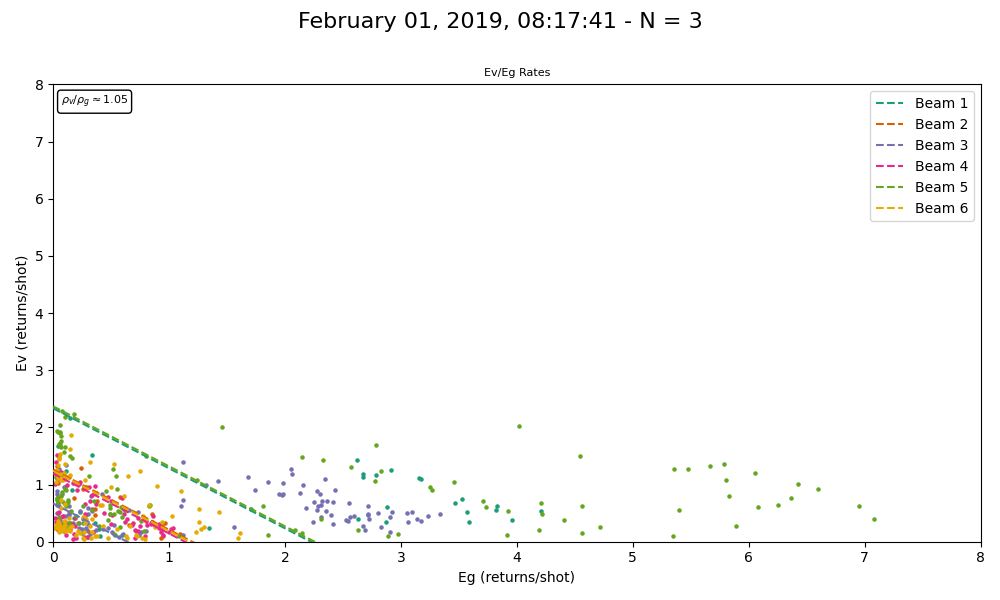

In [1]:
from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, cmap2, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
from scripts.classes_fixed import *
from scripts.pvpg_fixed import *
from scripts.track_pairs import *
from scripts.show_tracks import *
from scripts.parallel import pvpg_parallel_method2

%matplotlib ipympl

dirpath = '../data/rovaniemi_w/'
all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

for j in range(3,4):
    pvpg_parallel_method2(all_ATL03[j],all_ATL08[j],
                           init = -1,
                           # f_scale=.1,
                           loss = 'arctan',
                           zeros = False,
                           #beam = 5,
                           y_init = np.max, #alternatively np.mean
                           graph_detail = 1,
                           file_index=j)